In [16]:
import warnings
warnings.filterwarnings("ignore")

# We are going to import from the local path for models
# Because we are going to add more code 
import importlib
import sys
spec = importlib.util.spec_from_file_location("models", "finrl/agents/stablebaselines3/models.py")
models = importlib.util.module_from_spec(spec)
spec.loader.exec_module(models)

import pandas as pd
import numpy as np
import torch
import matplotlib
import matplotlib.pyplot as plt
# matplotlib.use('Agg')
import datetime

from finrl.config_tickers import DOW_30_TICKER
from finrl.meta.preprocessor.yahoodownloader import YahooDownloader
from finrl.meta.preprocessor.preprocessors import FeatureEngineer, data_split
from finrl.meta.env_stock_trading.env_stocktrading import StockTradingEnv
from finrl.plot import backtest_stats, backtest_plot, get_daily_return, get_baseline

from pprint import pprint

sys.path.append("../FinRL-Library")

import itertools

In [17]:
from typing import List
from stable_baselines3 import A2C
from stable_baselines3 import PPO
import scipy
from finrl.config_tickers import DOW_30_TICKER
from finrl.config import INDICATORS
import pandas as pd
import numpy as np
import datetime
from finrl.meta.preprocessor.yahoodownloader import YahooDownloader
from finrl.meta.preprocessor.preprocessors import FeatureEngineer
import torch
    
MODELS = {"a2c": A2C, "ppo": PPO}
seed = 0

In [18]:
# zscore normalization the features with rank inverse normal distribution and winsorize to remove outliers
def zscore_winsor(x: pd.Series, clip=4) -> pd.Series:
    # rank series and inverse normal distribution
    
    x = x.rank(method="average")/(len(x) + 1)
    x = x.apply(scipy.stats.norm.ppf).clip(-clip, clip)
    return x

def data_download_and_processing(date: str, DOW_30_TICKER: List[str]):
    df = YahooDownloader(start_date = '2020-01-01',
                     end_date = date,
                     ticker_list = DOW_30_TICKER).fetch_data()
    fe = FeatureEngineer(use_technical_indicator=True,
                     tech_indicator_list = INDICATORS,
                     use_turbulence=True,
                     user_defined_feature = False)
    processed = fe.preprocess_data(df)
    processed = processed.fillna(0)
    processed = processed.replace(np.inf,0)
    processed[INDICATORS] = processed.groupby(['date'])[INDICATORS].transform(zscore_winsor)
    return processed

In [19]:
def calculate_today_state(date: str, processed: pd.DataFrame, INDICATORS: List[str]):
    # date minus one business day
    date = pd.to_datetime(date)
    date = date - pd.tseries.offsets.BDay(1)
    date = date.strftime('%Y-%m-%d')
    processed_on_date = processed.loc[processed['date'] == date]
    state = (
            [1e6]
            + processed_on_date.close.values.tolist()
            + [0] * 29
            + sum(
                (
                    processed_on_date[tech].values.tolist()
                    for tech in INDICATORS
                ),
                [],
            )
        )
    state = np.array(state).reshape(1,-1)
    processed_on_date_ticker_list = processed_on_date.tic.tolist()
    return state, processed_on_date_ticker_list

In [20]:
def predict(k: int, model_zip_path: str, state: np.array, model_type: str, processed_on_date_ticker_list: List[str], seed: int = 0):
    model = MODELS[model_type].load(model_zip_path)
    torch.manual_seed(seed)
    with torch.no_grad():
        if torch.cuda.is_available():
            input_tensor = torch.from_numpy(state).to('cuda')
        else:
            input_tensor = torch.from_numpy(state)
        pred = model.policy(input_tensor)[0].cpu().numpy()
    pred = pred.flatten()
    # top k actions
    top_k = [processed_on_date_ticker_list[ticker_idx] for ticker_idx in pred.argsort()[-k:][::-1]]
    # bottom k actions
    bottom_k = [processed_on_date_ticker_list[ticker_idx] for ticker_idx in pred.argsort()[:k]]
    return top_k, bottom_k
    

In [21]:
# run all prediction pipelines
date = '2024-05-02'
if date > datetime.datetime.now().strftime("%Y-%m-%d"):
    raise ValueError("Date should not be in the future")
processed = data_download_and_processing(date, DOW_30_TICKER)
state, processed_on_date_ticker_list = calculate_today_state(date, processed, INDICATORS)

[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%*******

Shape of DataFrame:  (31610, 8)
Successfully added technical indicators
Successfully added turbulence index


In [22]:
# 90: lowest risk
model_zip_path = "trained_agents/PPO_10k_90.zip"
model_type = "ppo"

top_k, bottom_k = predict(5, model_zip_path, state, model_type, processed_on_date_ticker_list)
print(f"Top 5 actions: {top_k}")
print(f"Bottom 5 actions: {bottom_k}")

ppp_90_top = top_k
ppo_90_bottom = bottom_k

Top 5 actions: ['CAT', 'V', 'INTC', 'CRM', 'WMT']
Bottom 5 actions: ['TRV', 'CVX', 'AAPL', 'GS', 'AMGN']


In [33]:
# 120: medium risk
model_zip_path = "trained_agents/PPO_10k_120.zip"
model_type = "ppo"

top_k, bottom_k = predict(5, model_zip_path, state, model_type, processed_on_date_ticker_list)
print(f"Top 5 actions: {top_k}")
print(f"Bottom 5 actions: {bottom_k}")

ppp_120_top = top_k
ppo_120_bottom = bottom_k

Top 5 actions: ['CAT', 'INTC', 'V', 'CRM', 'MSFT']
Bottom 5 actions: ['TRV', 'CVX', 'GS', 'AMGN', 'AAPL']


In [34]:
# inf: high risk
model_zip_path = "trained_agents/PPO_10k_inf.zip"
model_type = "ppo"

top_k, bottom_k = predict(5, model_zip_path, state, model_type, processed_on_date_ticker_list)
print(f"Top 5 actions: {top_k}")
print(f"Bottom 5 actions: {bottom_k}")

ppo_inf_top = top_k
ppo_inf_bottom = bottom_k

Top 5 actions: ['INTC', 'CAT', 'V', 'CRM', 'WMT']
Bottom 5 actions: ['TRV', 'CVX', 'GS', 'AMGN', 'AAPL']


In [30]:
# 90: lowest risk
model_zip_path = "trained_agents/A2C_10k_90.zip"
model_type = "a2c"

top_k, bottom_k = predict(5, model_zip_path, state, model_type, processed_on_date_ticker_list)
print(f"Top 5 actions: {top_k}")
print(f"Bottom 5 actions: {bottom_k}")

a2c_90_top = top_k
a2c_90_bottom = bottom_k

Top 5 actions: ['WMT', 'HON', 'MRK', 'INTC', 'DIS']
Bottom 5 actions: ['TRV', 'CVX', 'PG', 'AAPL', 'GS']


In [31]:
# 120: medium risk
model_zip_path = "trained_agents/A2C_10k_120.zip"
model_type = "a2c"

top_k, bottom_k = predict(5, model_zip_path, state, model_type, processed_on_date_ticker_list)
print(f"Top 5 actions: {top_k}")
print(f"Bottom 5 actions: {bottom_k}")

a2c_120_top = top_k
a2c_120_bottom = bottom_k

Top 5 actions: ['MSFT', 'INTC', 'JPM', 'CAT', 'IBM']
Bottom 5 actions: ['CVX', 'GS', 'TRV', 'PG', 'AXP']


In [32]:
# inf: high risk
model_zip_path = "trained_agents/A2C_10k_inf.zip"
model_type = "a2c"

top_k, bottom_k = predict(5, model_zip_path, state, model_type, processed_on_date_ticker_list)
print(f"Top 5 actions: {top_k}")
print(f"Bottom 5 actions: {bottom_k}")

a2c_inf_top = top_k
a2c_inf_bottom = bottom_k

Top 5 actions: ['WMT', 'MRK', 'BA', 'V', 'CAT']
Bottom 5 actions: ['TRV', 'GS', 'JNJ', 'KO', 'AAPL']


/var/folders/cd/9g57q0v53dn9sp33pkd70zqr0000gn/T/ipykernel_82032/1574309807.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_selected['date'] = pd.to_datetime(df_selected['date'])


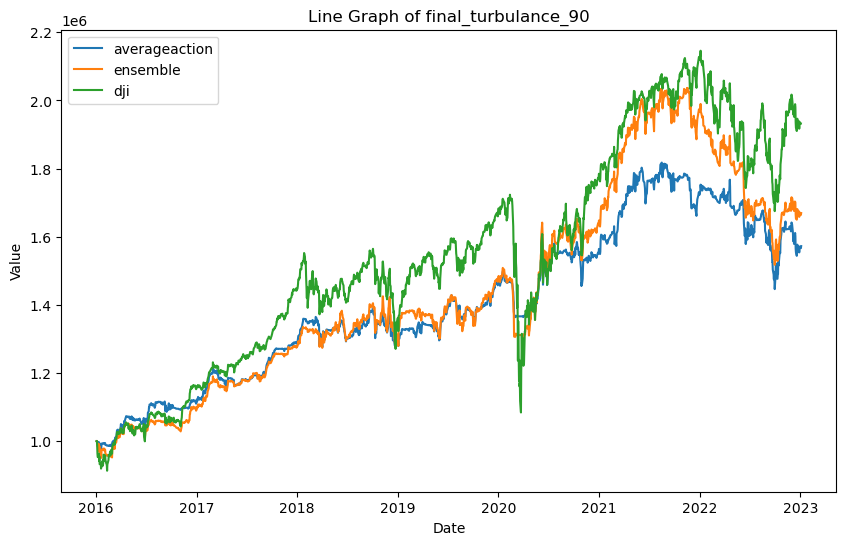

In [11]:
import pandas as pd
import matplotlib.pyplot as plt

df = pd.read_excel('result summary final_turbulance_90.xlsx')
selected_columns = ['date', 'averageaction', 'ensemble', 'dji']
df_selected = df[selected_columns]
df_selected['date'] = pd.to_datetime(df_selected['date'])

df_selected.set_index('date', inplace=True)

plt.figure(figsize=(10, 6))
for column in df_selected.columns:
    plt.plot(df_selected.index, df_selected[column], label=column)

plt.xlabel('Date')
plt.ylabel('Value')
plt.title('Line Graph of final_turbulance_90')
plt.legend()

plt.savefig("../ai_trader/frontend/src/components/result_final_turbulance_90.png")
plt.show()


/var/folders/cd/9g57q0v53dn9sp33pkd70zqr0000gn/T/ipykernel_82032/2766920075.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_selected['date'] = pd.to_datetime(df_selected['date'])


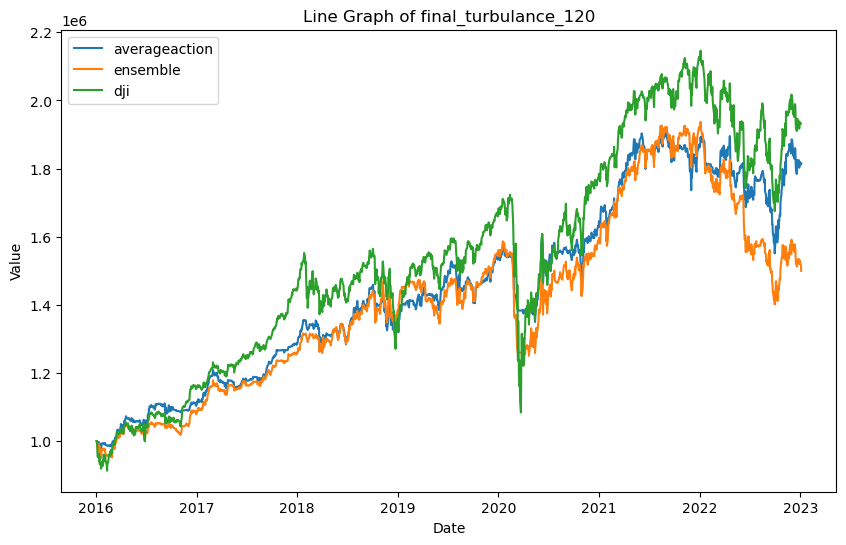

In [13]:
df = pd.read_excel('result summary final_turbulance_120.xlsx')
selected_columns = ['date', 'averageaction', 'ensemble', 'dji']
df_selected = df[selected_columns]
df_selected['date'] = pd.to_datetime(df_selected['date'])

df_selected.set_index('date', inplace=True)

plt.figure(figsize=(10, 6))
for column in df_selected.columns:
    plt.plot(df_selected.index, df_selected[column], label=column)

plt.xlabel('Date')
plt.ylabel('Value')
plt.title('Line Graph of final_turbulance_120')
plt.legend()

plt.savefig("../ai_trader/frontend/src/components/result_final_turbulance_120.png")
plt.show()

/var/folders/cd/9g57q0v53dn9sp33pkd70zqr0000gn/T/ipykernel_82032/389131326.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_selected['date'] = pd.to_datetime(df_selected['date'])


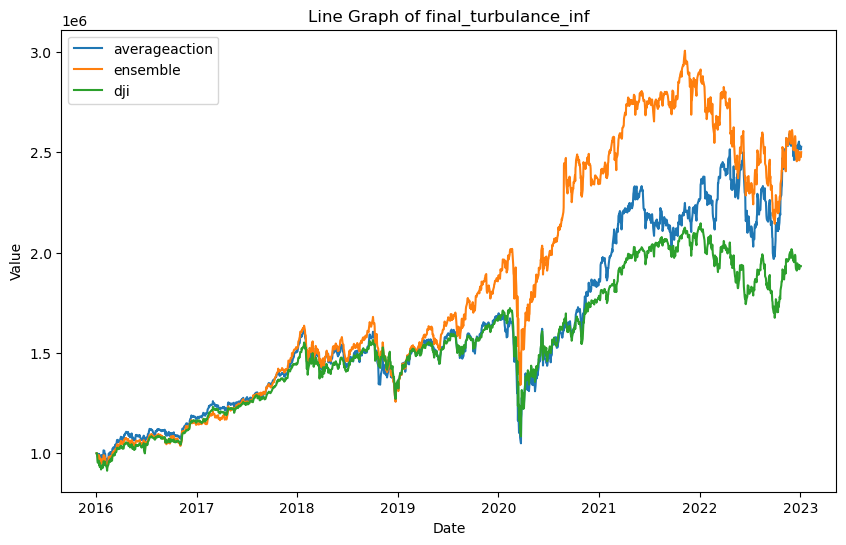

In [14]:
df = pd.read_excel('result summary final_turbulance_inf.xlsx')
selected_columns = ['date', 'averageaction', 'ensemble', 'dji']
df_selected = df[selected_columns]
df_selected['date'] = pd.to_datetime(df_selected['date'])

df_selected.set_index('date', inplace=True)

plt.figure(figsize=(10, 6))
for column in df_selected.columns:
    plt.plot(df_selected.index, df_selected[column], label=column)

plt.xlabel('Date')
plt.ylabel('Value')
plt.title('Line Graph of final_turbulance_inf')
plt.legend()

plt.savefig("../ai_trader/frontend/src/components/result_final_turbulance_inf.png")
plt.show()

In [35]:
import json

data = {'ppp_90_top': ppp_90_top, 
        'ppo_90_bottom': ppo_90_bottom,
        'ppo_120_top': ppp_120_top,
        'ppo_120_bottom': ppo_120_bottom, 
        'ppo_inf_top': ppo_inf_top,
        'ppo_inf_bottom': ppo_inf_bottom,
        'a2c_90_top': a2c_90_top, 
        'a2c_90_bottom': a2c_90_bottom,
        'a2c_120_top': a2c_120_top,
        'a2c_120_bottom': a2c_120_bottom, 
        'a2c_inf_top': a2c_inf_top,
        'a2c_inf_bottom': a2c_inf_bottom
        }

json_path = '../ai_trader/frontend/src/components/data.json'

# Save to file
with open(json_path, 'w') as f:
    json.dump(data, f)

# Load from file
with open(json_path, 'r') as f:
    loaded_data = json.load(f)

In [37]:
selected_df = df[['date', 'averageaction']]

In [66]:
json_path_po = '../ai_trader/frontend/src/components/perf_overview.json'
selected_df.to_json(json_path_po, orient='records')


In [70]:
cols = ['Annualized Returns 2016-2022','averageaction.3', 'ensemble.3', 'dji.3', 'minvar.3', 'tangent.3']
df = pd.read_excel('result summary final_turbulance_90.xlsx')
df_selected = df[cols]
sum_df = df_selected[:3]
plt.figure(figsize=(10, 6))  # Adjust the figure size as needed
plt.table(cellText=sum_df.values, colLabels=sum_df.columns, cellLoc='center', loc='center', colWidths=[0.2]*len(sum_df.columns))
plt.axis('off')  # Hide axis
plt.title('Annualized Returns 2016-2022')  # Add title
plt.savefig("../ai_trader/frontend/src/components/Annualized_90.png")


In [71]:
cols = ['Annualized Returns 2016-2022','averageaction.3', 'ensemble.3', 'dji.3', 'minvar.3', 'tangent.3']
df = pd.read_excel('result summary final_turbulance_120.xlsx')
df_selected = df[cols]
sum_df = df_selected[:3]
plt.figure(figsize=(10, 6))  # Adjust the figure size as needed
plt.table(cellText=sum_df.values, colLabels=sum_df.columns, cellLoc='center', loc='center', colWidths=[0.2]*len(sum_df.columns))
plt.axis('off')  # Hide axis
plt.title('Annualized Returns 2016-2022')  # Add title
plt.savefig("../ai_trader/frontend/src/components/Annualized_120.png")

In [72]:
cols = ['Annualized Returns 2016-2022','averageaction.3', 'ensemble.3', 'dji.3', 'minvar.3', 'tangent.3']
df = pd.read_excel('result summary final_turbulance_inf.xlsx')
df_selected = df[cols]
sum_df = df_selected[:3]
plt.figure(figsize=(10, 6))  # Adjust the figure size as needed
plt.table(cellText=sum_df.values, colLabels=sum_df.columns, cellLoc='center', loc='center', colWidths=[0.2]*len(sum_df.columns))
plt.axis('off')  # Hide axis
plt.title('Annualized Returns 2016-2022')  # Add title
plt.savefig("../ai_trader/frontend/src/components/Annualized_inf.png")